# 课程设计要求

参见报告模板

# 肺实质区域提取

CT影像在疾病诊治中发挥了重要作用，特别对肺部的疾病检查具有无可替代的作用。

肺部的疾病通常表现为肺实质区域内的病变，在CT影像中具有显著的特征。

医生可以通过检查病人的肺CT影像进行肺部的疾病诊断。

利用人工智能进行CT影像的阅片能够提高效率，推进医能医闻的发展。

开发自动的CT阅片，如下图所示，主要包括两个步骤：1）肺实质区域的的提取；2）肺实质区域内疾病的诊断。

![肺部CT](https://ai-studio-static-online.cdn.bcebos.com/25c2843a32b3411fbecfc42a6b77bba856a774b028014b0db560a773e96d622a)


本次课程设计，就要实现第1步，进行肺实质区域的提取。



In [1]:
%pip install SimpleITK
%pip install matplotlib
%pip install numpy
%pip install pillow 
%pip install python-opencv 
%pip install ipywidgets

Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/
ERROR: Could not find a version that satisfies the requirement python-opencv (from versions: none)
ERROR: No matching distribution found for python-opencv
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: 

In [2]:
from ipywidgets import interact
import SimpleITK as sitk
import numpy as np
import pandas
import matplotlib.pyplot as plt
import glob
print(sitk.Version())

SimpleITK Version: 2.5.2 (ITK 5.4)
Compiled: Jun 13 2025 19:16:44



## 1.解析数据

使用LUNA16数据，包含用于肺结节检测的CT影像。关于LUNA16数据集的介绍参考：https://cloud.tencent.com/developer/article/1632427

只使用其中的subset0数据集，将subset0数据集解压到work目录里： /work/subset0

In [3]:
#设置CT数据的路径
image_paths='./lungmaterial/data/*.mhd'    
ctpaths=glob.glob(image_paths)
ctpaths #从列出的CT数据路径，每一个路径是一个病人的CT断层扫描结果

['./lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.mhd',
 './lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991.mhd',
 './lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411.mhd',
 './lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.mhd',
 './lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.mhd',
 './lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd',
 './lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321.mhd',
 './lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd',
 './lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.mhd']

### 1.1 自定义解析器

In [4]:
import struct
def loadctdata(mhdpath='/ab.mhd'):
    #从luna16数据集中加载原始的影像，但不包括坐标信息，返回一个cxhxw的数组
    def parsemeta(mhdfile):
        data={}
        with open(mhdfile) as f:
            for l in f:
                tmp=l.split(' = ')
                data[tmp[0].strip()]=tmp[1].strip()
        return data 
    metadata=parsemeta(mhdpath)
    metadata['mdhpath']=mhdpath
    path=mhdpath.replace('.mhd','.raw')
    #f=open(path,"rb")
    #data=f.read()
    #number=len(data)//2
    #ctdata=struct.unpack('h'*number,data)
    #ctarray=np.array(ctdata).reshape((-1,512,512))
    ctarray=np.fromfile(path,dtype=np.int16)
    return ctarray.reshape((-1,512,512)),metadata

In [5]:
ctpath='./lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.mhd'  #ctpaths[3]#
data,metadata=loadctdata(ctpath) #ctpaths[10])#
metadata  #包含了一些基本CT影像信息

{'ObjectType': 'Image',
 'NDims': '3',
 'BinaryData': 'True',
 'BinaryDataByteOrderMSB': 'False',
 'CompressedData': 'False',
 'TransformMatrix': '1 0 0 0 1 0 0 0 1',
 'Offset': '-215.199997 -196 -364.5',
 'CenterOfRotation': '0 0 0',
 'AnatomicalOrientation': 'RAI',
 'ElementSpacing': '0.8203120231628418 0.8203120231628418 2.5',
 'DimSize': '512 512 133',
 'ElementType': 'MET_SHORT',
 'ElementDataFile': '1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.raw',
 'mdhpath': './lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.mhd'}

(133, 512, 512)
CT影像的范围（Hu）：
-2048 3071


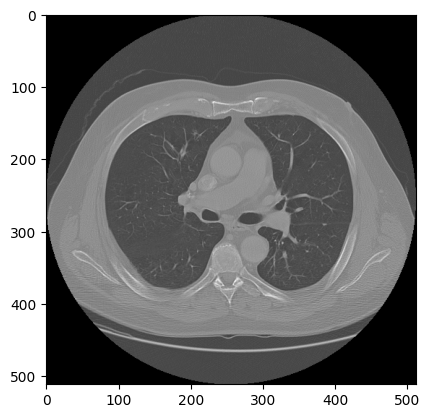

In [6]:
#查看读取数据的基本信息
print(data.shape)  #显示CT影像格式为(C,H,W)，C表示切层数，H和W表示高和宽
print('CT影像的范围（Hu）：')
print(data.min(),data.max())  
plt.imshow(data[80],cmap='gray')    
plt.show()

### 1.2 利用SimpleITK加载

[-215.199997 -196.       -364.5     ] [0.82031202 0.82031202 2.5       ]
(133, 512, 512)


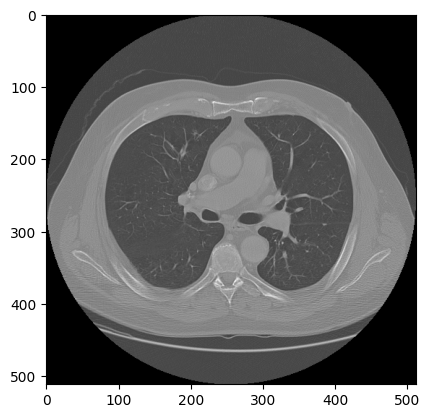

In [7]:
ctimage = sitk.ReadImage(ctpath)
numpyOrigin = np.array(list(ctimage.GetOrigin()))      #影像的起点坐标x,y,z
numpySpacing = np.array(list(ctimage.GetSpacing()))    #像素尺寸，dx,dy,dz
print(numpyOrigin, numpySpacing)
data = sitk.GetArrayFromImage(ctimage)                 #读取所有数据
print(data.shape)
plt.imshow(data[80],cmap='gray')                       #与上方解析的结果相同
plt.show()

## 2. 基于Hu值的初步提取

在以上打开的CT数据中，已经将数值变换为Hu值。

CT扫描图是包含了所有组织的，若直接去查看，则看不到任何有用信息。需要做一些预处理，预处理中一个重要的概念是放射剂量，衡量单位为 HU
(Hounsfield Unit)，下表列出了不同放射剂量对应的组织器官：

![Hu值](https://ai-studio-static-online.cdn.bcebos.com/26a45e1d8fff4a9ba04ee98860e8fd2e4c402219a7ae4242b478cddcae30be96)


## 2.1 观察CT图像

可以利用jupyter的交互性，制作一个简单的CT阅片工具，方便进行CT影像的观察：

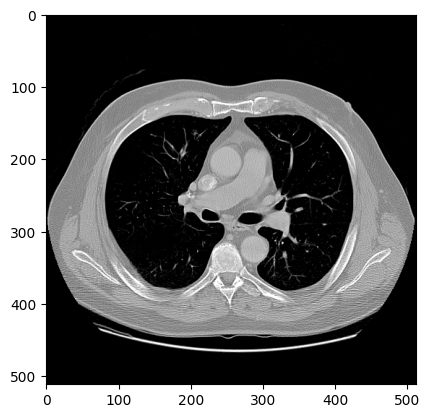

interactive(children=(IntSlider(value=80, description='z', max=132), IntSlider(value=-150, description='th', m…

In [8]:
def ctwinfunc(x,thresh=-500,window=100):
    if x>thresh+window/2:
        return thresh+window/2
    if x<thresh-window/2:
        return thresh-window/2  
    return x  
vctwinfunc=np.vectorize(ctwinfunc,excluded=['thresh','window'])
def ctwin(z=80,th=-150,ww=1400):
    #回调函数
    r=vctwinfunc(data[z],th,ww)
    plt.imshow(r,cmap='gray')
    plt.show()

#可以利用动态交互工具来实时调节不同
t=interact(ctwin, z=(0,data.shape[0]-1,1),th=(-600,400,10),ww=(1,1500,10)) #控件

## 2.2 利用肺窗进行肺实质区域提取

In [9]:
def extract(x,high=-500,low=-1000): #请根据论文《用于肺结节检测和分类的两阶段深度学习方法》检查该方法的正确性
    if low<x<high:
        return 1
    return 0
vextract=np.vectorize(extract,excluded=['high','low'])


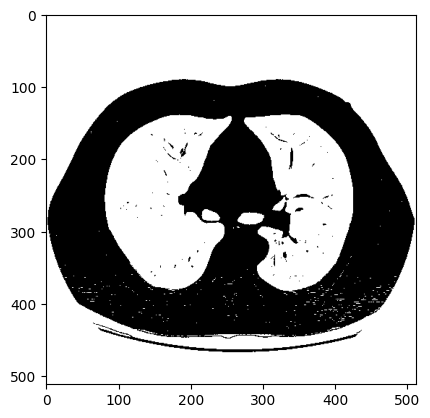

In [10]:
r=vextract(data[80],-300,-2900)  #使用窗函数进行阈值分割
plt.imshow(r,cmap='gray')
plt.show()

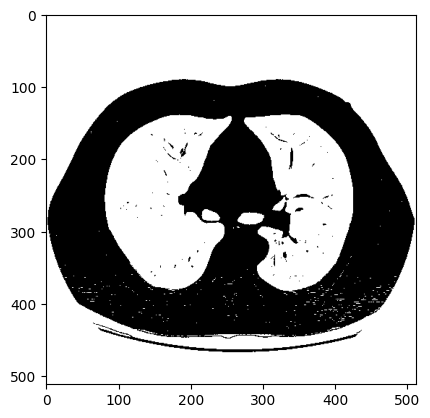

interactive(children=(IntSlider(value=80, description='z', max=132), IntSlider(value=-300, description='high',…

In [11]:
#通过交互式功能找到最优的阈值
def tmp2(z=80,high=-300,low=-2400):
    #回调函数
    r=vextract(data[z],high,low)
    plt.imshow(r,cmap='gray')
    plt.show()

#可以利用动态交互工具来实时调节不同范围，寻找最优阈值
t=interact(tmp2, z=(0,data.shape[0]-1,1),high=(-1000,0,10),low=(-2400,-800,10)) #控件

从以上的结果可以看出，找到两个阈值，从而能够较好的提取出肺实质区域。

但是也存在着问题：1）提取结果的外围需要去除；2）还会有一些小的噪声或者气管的影响；3）肺实质中间的孔洞需要填充。

## 2.3 噪声的去除

在去除外围边界后，仍然存留有少量的零散噪声。

零散噪声的去除可以通过开运算完成。

In [12]:
def make_neibor(imgar,kernel_size=3,pattern=None,pad_value=0):
    #对mxn大小的数组以kernel_size大小的邻域展开，kernel_size可以是一个奇数表示方形邻域，也可以是一个两个奇数元素的无组
    #pattern为一个kernel_size大小的0-1二维数组，表示邻域的形状，pattern的优先级大于kernel_size,如果都设置以pattern为主
    #带有常数值填充的
    #需要注意的是该邻域展开方法只适用于二维数组（灰度图像）
    if isinstance(pattern,np.ndarray) and pattern.ndim==2:
        kernel_size=pattern.shape
    else:
        if isinstance(kernel_size, int):
            kernel_size=kernel_size,kernel_size
            pattern=np.ones(kernel_size ,dtype=np.uint8)
        elif isinstance(kernel_size,tuple) and len(kernel_size)==2:
            pattern=np.ones(kernel_size ,dtype=np.uint8)
        else:
            raise Exception('wrong kernel type, kernel should be a int type or  a tuple of tow int value')
    pady=kernel_size[0]//2
    padx=kernel_size[1]//2

    h,w=imgar.shape[:2]
    padar=np.pad( imgar,pad_width=((pady,pady),(padx,padx)),mode='constant',constant_values=pad_value)
    r,c=kernel_size
    neighbors=[padar[y:y+h,x:x+w]  for y in range(r) for x in range(c) if pattern[y,x]>0.5]
    return np.dstack(neighbors)

def dilate(imgar,pattern=None):
    #膨胀运算
    pattern=np.ones((3,3))  if pattern is None else pattern
    nb=make_neibor(imgar,pattern=pattern)
    return  nb.any(axis=2) if imgar.dtype==bool else nb.max(axis=2) 

def erosion(imgar,pattern=None):
    #腐蚀运算
    pattern=np.ones((3,3))  if pattern is None else pattern
    nb=make_neibor(imgar,pattern=pattern)
    return  nb.all(axis=2) if imgar.dtype==bool else nb.min(axis=2) 

def mopen(ar,pattern=None):
    #形态学开运算
    pattern=np.ones((3,3))  if pattern is None else pattern
    ear=erosion(ar,pattern)
    return dilate(ear,pattern)

def mclose(ar,pattern=None):
    #形态学闭运算
    pattern=np.ones((3,3))  if pattern is None else pattern
    dar=dilate(ar,pattern)
    return erosion(dar,pattern)

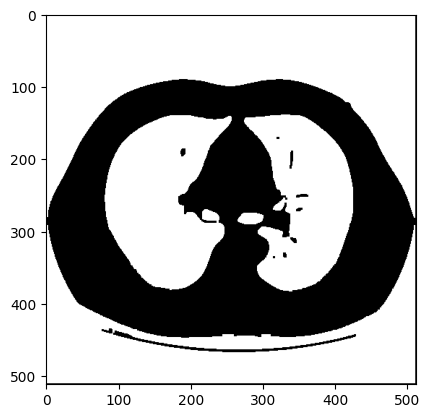

In [13]:
#进行开操作
zr=mopen(r,5)
zr=mclose(zr,7)   #调节不同尺寸观察效果，特别是不同的rr
plt.imshow(zr,cmap='gray')
plt.show()

## 2.4 外围区域的去除

一般使用OpenCV提供的方法进行外部区域的去除。

In [14]:
import cv2

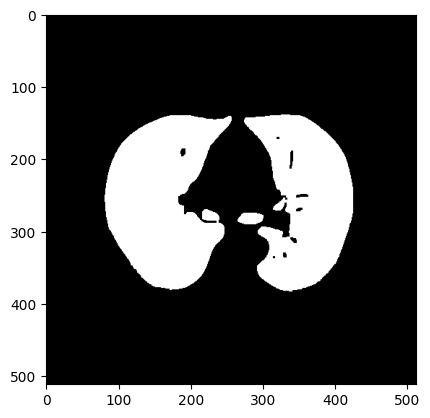

In [15]:
rr=np.copy(zr).astype(np.uint8)
h,w=r.shape
mask = np.zeros([h+2, w+2], np.uint8)
rr[:,:5]=1
rr[:,-5:]=1
rr[-5:,:]=1
cv2.floodFill(rr, mask, (0, 0), 0)  
#cv2.floodFill(rr, mask, (h-1, 0), 0)  
plt.imshow(rr,cmap='gray')
plt.show()


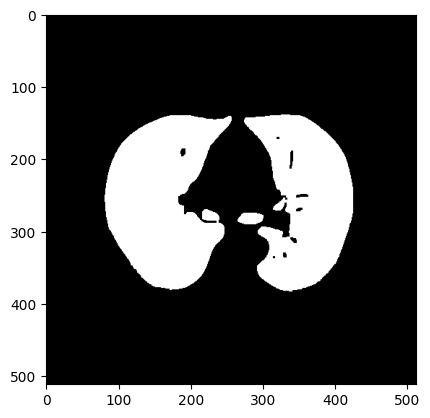

interactive(children=(IntSlider(value=80, description='z', max=132), IntSlider(value=-300, description='high',…

In [16]:
#通过交互式功能
def tmp3(z=80,high=-300,low=-2400):
    #回调函数
    r=vextract(data[z],high,low).astype(np.uint8)
    r=mopen(r,5)
    r=mclose(r,7)
    h,w=r.shape
    mask = np.zeros([h+2, w+2], np.uint8)
    r[:,:5]=1
    r[:,-5:]=1
    r[-5:,:]=1
    cv2.floodFill(r, mask, (0, 0), 0)  
    plt.imshow(r,cmap='gray')
    plt.show()

#可以利用动态交互工具来实时调节不同范围，寻找最优阈值
t=interact(tmp3, z=(0,data.shape[0]-1,1),high=(-1000,0,10),low=(-2400,-800,10)) #控件

> 问题：请想一想为什么要将CT的3条边进行置0操作？这样做的意义是？

## 2.5 填充内部区域

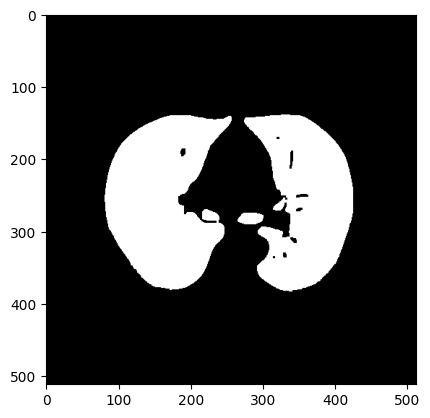

In [17]:
#使用闭操作
qr=mclose(rr,11)     #调节不同的值观察效果
plt.imshow(qr,cmap='gray')
plt.show()

## 2.6 孔洞的填充

参考以下资料：[二值图孔洞填充方法与实现](https://cloud.tencent.com/developer/article/1877771)

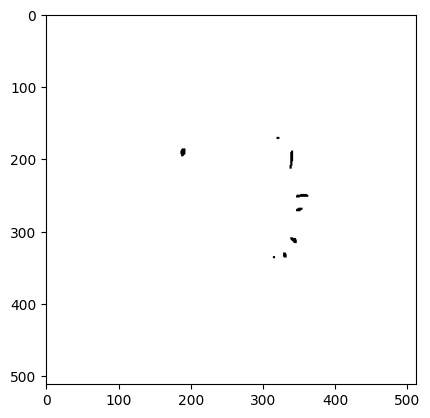

In [18]:
ar=np.copy(qr)
h,w=ar.shape
mask = np.zeros([h+2, w+2], np.uint8)
cv2.floodFill(ar, mask, (0, 0), 1)  
plt.imshow(ar,cmap='gray')
plt.show()

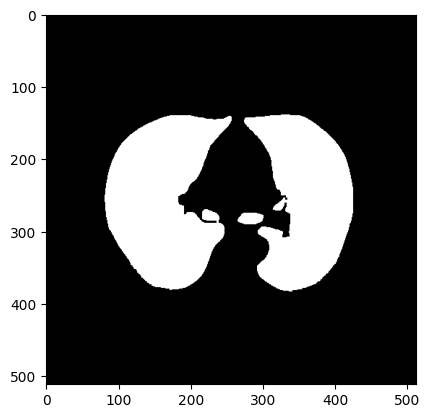

In [19]:
br=(1-ar)+qr
plt.imshow(br,cmap='gray')
plt.show()

## 2.7 提取肺实质

通过上述的模板，对图像进掩码运算，即可得到肺实质区域的提取结果。

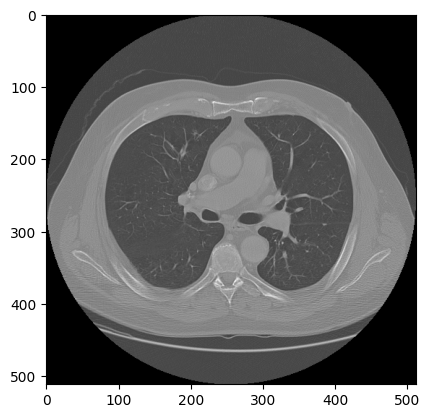

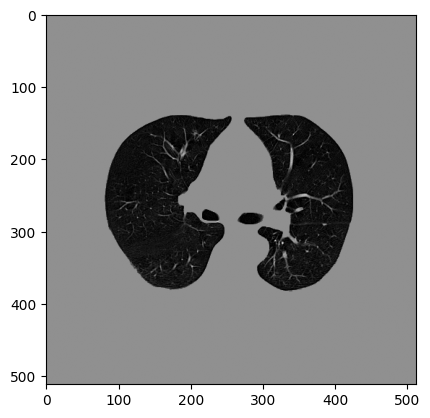

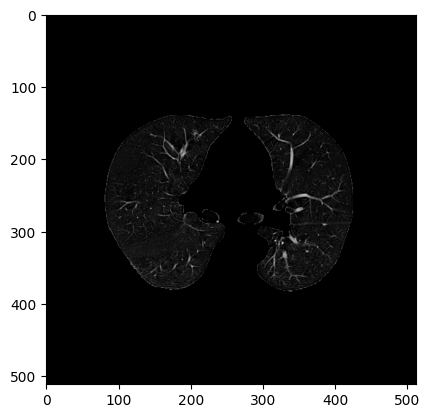

In [20]:
ct1=data[80]
plt.imshow(ct1,cmap='gray')  #显示原图
plt.show()
res=ct1*br                   
plt.imshow(res,cmap='gray')  #显示蒙板运算结果
plt.show()
mv=(1-br)*res.min()          
res=res+mv                   #将蒙板调节到最小值显示为黑色
plt.imshow(res,cmap='gray') 
plt.show()

## 2.8 持久化保存

由于提取的结果数据类型不是0-255的整数，需要进行缩放后才可以保存，或者调整后进行保存。

参考论文：\[用于肺结节检测和分类的两阶段深度学习方法\]，采用：对于肺部CT，CT值大于600Hu，则说明不是肺部组织，因此，选取归一化阈值为\[1200-600\]，将该范围归一化到\[0-255\]区间。

使用PIL库保存为图像，方便后续疾病的诊断。

In [21]:
from PIL import Image
rimg=np.clip(res,-1000, 600)
rimg=(rimg+1000)/(600+1000)*255
Image.fromarray(rimg.astype(np.uint8),'L').save('80.png')

# 3. 结论


通过以上的步骤，我们就能较好的完成肺实质区域的提取，为进一步肺部疾病的诊断创建了较好的基础。

In [30]:
!pip install numpy opencv-python SimpleITK scikit-image scipy matplotlib

Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/


In [53]:
# ===================================================================
# 课程设计：CT影像中的肺实质区域提取 (最终优化版)
#
# 整合了高效的批量处理流程和详尽的单切片可视化分析功能。
# ===================================================================

import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import measure, morphology
import cv2  # 导入OpenCV用于轮廓检测

# --- 用户配置 ---
# 如果您尚未安装opencv-python，请取消下面的注释并运行一次
# !pip install opencv-python

print("✅ 所有库已成功导入！")

✅ 所有库已成功导入！


单元 2: 核心分割函数 (已优化，可输出中间步骤)
这个函数是算法的核心。我已将其修改，使之不仅返回最终的肺部掩码，还返回一个包含中间结果的字典，方便后续的可视化。


In [58]:
def segment_lung_mask(img_slice, hu_threshold=-320):
    """
    对单个CT切片进行肺实质分割，并返回中间处理步骤。

    参数:
    - img_slice (np.ndarray): 一个2D NumPy数组，代表单个CT切片。
    - hu_threshold (int): 用于区分空气/肺部和软组织的Hounsfield单位阈值。

    返回:
    - lung_mask (np.ndarray): 最终的二值化(0或1)肺实质掩码。
    - intermediate_steps (dict): 包含中间处理结果的字典，用于可视化。
    """
    # 步骤 1: 阈值处理，初步分离出密度较低的区域（包括肺部和外部空气）。
    binary_image = np.array(img_slice > hu_threshold, dtype=np.int8)
    
    # 步骤 2: 移除与图像边界相连的区域，这步可以有效去除图像外的空气。
    labels = measure.label(binary_image)
    background_label = labels[0, 0]  # 获取(0,0)点像素的标签作为背景标签
    binary_image[labels == background_label] = 0
    
    # 步骤 3: 形态学处理，优化二值图像。
    # a. 闭运算：填充肺部内部因血管等造成的小型空洞。
    # b. 开运算：移除肺外部可能存在的孤立小噪点。
    closed_image = morphology.closing(binary_image, morphology.disk(10))
    opened_image = morphology.opening(closed_image, morphology.disk(5))
    
    # 步骤 4: 连通组件分析，识别并选取真正的肺部区域。
    # 经过处理后，左、右肺通常是图像中面积最大和次大的两个连通区域。
    labels = measure.label(opened_image)
    regions = measure.regionprops(labels)
    
    sorted_regions = sorted(regions, key=lambda x: x.area, reverse=True)
    
    final_mask = np.zeros_like(img_slice, dtype=bool)
    if len(sorted_regions) > 1:
        # 正常情况，保留最大的两个区域
        lung_labels = [sorted_regions[0].label, sorted_regions[1].label]
        final_mask = np.isin(labels, lung_labels)
    elif len(sorted_regions) > 0:
        # CT扫描的顶部或底部，可能只包含一个肺叶区域
        final_mask = labels == sorted_regions[0].label

    # 步骤 5: 最终空洞填充，确保肺实质掩码是实心的。
    final_mask = ndi.binary_fill_holes(final_mask)
    
    # 准备返回结果
    lung_mask_uint8 = final_mask.astype(np.uint8)
    intermediate_steps = {
        "thresholded": binary_image,
        "morphed": opened_image
    }
    
    return lung_mask_uint8, intermediate_steps

print("✅ 核心分割函数 'segment_lung_mask' 定义完成。")

✅ 核心分割函数 'segment_lung_mask' 定义完成。


In [59]:
def show_detailed_analysis(ct_slice, slice_idx, mask, intermediate_steps, save_path=None):
    """
    生成一个包含多维度分析的详细可视化图表。
    """
    plt.figure(figsize=(20, 15))
    has_lung = np.sum(mask) > 0

    # === 行 1: 主要结果展示 ===
    plt.subplot(3, 4, 1)
    plt.imshow(ct_slice, cmap='gray')
    plt.title(f'原始CT第{slice_idx}层\nHU: [{ct_slice.min():.0f}, {ct_slice.max():.0f}]', fontsize=12)
    plt.axis('off')

    plt.subplot(3, 4, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'最终肺掩码 (Mask)\n像素数: {np.sum(mask):,}', fontsize=12)
    plt.axis('off')

    plt.subplot(3, 4, 3)
    lung_result = ct_slice * mask
    plt.imshow(lung_result, cmap='gray')
    if has_lung:
        plt.title(f'肺实质提取结果', fontsize=12)
    else:
        plt.title('肺实质提取结果\n⚠️ 未检测到肺', fontsize=12, color='red')
    plt.axis('off')

    plt.subplot(3, 4, 4)
    plt.imshow(ct_slice, cmap='gray', alpha=0.8)
    if has_lung:
        plt.imshow(mask, cmap='Reds', alpha=0.25)
    plt.title('提取结果叠加显示', fontsize=12)
    plt.axis('off')

    # === 行 2: 处理步骤与统计 ===
    plt.subplot(3, 4, 5)
    threshold_result = intermediate_steps['thresholded']
    plt.imshow(threshold_result, cmap='gray')
    plt.title(f'步骤1: 阈值分割', fontsize=12)
    plt.axis('off')

    plt.subplot(3, 4, 6)
    morph_result = intermediate_steps['morphed']
    plt.imshow(morph_result, cmap='gray')
    plt.title(f'步骤2: 形态学处理', fontsize=12)
    plt.axis('off')

    plt.subplot(3, 4, 7)
    contour_img_display = np.zeros_like(mask)
    if has_lung:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(contour_img_display, contours, -1, 255, 2)
    plt.imshow(contour_img_display, cmap='magma')
    plt.title(f'步骤3: 提取的轮廓', fontsize=12)
    plt.axis('off')

    plt.subplot(3, 4, 8)
    plt.axis('off')
    total_pixels = mask.size
    lung_pixels = np.sum(mask)
    lung_percentage = (lung_pixels / total_pixels * 100) if total_pixels > 0 else 0
    stats_text = f"统计信息:\n\n总像素: {total_pixels:,}\n肺像素: {lung_pixels:,}\n肺占比: {lung_percentage:.1f}%\n"
    if has_lung:
        lung_hu = ct_slice[mask > 0]
        stats_text += f"""\n肺实质HU值:\n- 均值: {lung_hu.mean():.1f}\n- 标准差: {lung_hu.std():.1f}\n- 范围: [{lung_hu.min():.0f}, {lung_hu.max():.0f}]"""
    else:
        stats_text += "\n⚠️ 警告: 无肺区域"
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=11, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="lightgreen" if has_lung else "lightyellow", alpha=0.8))

    # === 行 3: 深度分析 ===
    plt.subplot(3, 4, 9)
    plt.hist(ct_slice.flatten(), bins=80, color='blue', alpha=0.6, label='全图像')
    if has_lung:
        plt.hist(ct_slice[mask > 0], bins=50, color='red', alpha=0.7, label='肺实质')
    plt.xlabel('HU值')
    plt.ylabel('像素数量')
    plt.title('HU值分布直方图', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    
    plt.subplot(3, 4, 10)
    plt.imshow(ct_slice, cmap='gray')
    if has_lung:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(plt.gca().get_images()[0].get_array(), contours, -1, (255, 0, 0), 1)
        plt.imshow(mask, cmap='viridis', alpha=0.2)
        plt.title(f'轮廓叠加 (共{len(contours)}个)', fontsize=12)
    else:
        plt.title('轮廓检测\n⚠️ 无轮廓', fontsize=12, color='red')
    plt.axis('off')

    plt.subplot(3, 4, 11)
    if has_lung:
        y, x = np.mgrid[0:mask.shape[0], 0:mask.shape[1]]
        plt.contourf(x, y, ndi.gaussian_filter(ct_slice * mask, sigma=3), levels=15, cmap='plasma')
        plt.title('肺实质区域等高线图', fontsize=12)
        plt.axis('equal')
    else:
        plt.text(0.5, 0.5, '无数据', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('等高线图 (无数据)', fontsize=12)
    plt.axis('off')

    plt.subplot(3, 4, 12)
    plt.axis('off')
    if has_lung:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        areas = [cv2.contourArea(c) for c in contours]
        analysis_text = f"区域分析:\n\n轮廓数量: {len(contours)}\n总面积: {sum(areas):.0f} px\n"
        if len(contours) > 0:
            analysis_text += f"最大区域面积: {max(areas):.0f} px\n\n"
        analysis_text += f"质量评估:\n- 连通性: {'良好' if 1 <= len(contours) <= 2 else '可能异常'}\n- 有效性: {'有效切片' if lung_percentage > 1 else '可能无效'}"
    else:
        analysis_text = "区域分析:\n\n⚠️ 未检测到有效轮廓"
    plt.text(0.05, 0.95, analysis_text, transform=plt.gca().transAxes, fontsize=11, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.8))

    plt.tight_layout(pad=1.5)
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        print(f"📊 详细分析图已保存到: {save_path}")
    
    plt.show()

print("✅ 增强型可视化函数 'show_detailed_analysis' 定义完成。")

✅ 增强型可视化函数 'show_detailed_analysis' 定义完成。


In [60]:
def run_lung_segmentation_pipeline(ct_path, output_dir, report_dir):
    """
    执行完整的肺实质分割流程：加载数据、批量处理、保存结果、并进行可视化分析。
    """
    print("="*60)
    print("🚀 开始执行肺实质提取流程...")
    print(f"CT影像路径: {ct_path}")
    print("="*60)

    # --- 1. 加载数据 ---
    if not os.path.exists(ct_path):
        print(f"❌ 致命错误: 文件未找到！请确认文件路径是否正确。")
        print(f"   检查路径: {ct_path}")
        print("   提示: 请确保 .mhd 和 .raw 文件都在与此Notebook相同的目录下。")
        return

    print("⏳ 正在加载CT影像...")
    try:
        sitk_image = sitk.ReadImage(ct_path)
        ct_scan = sitk.GetArrayFromImage(sitk_image)
        num_slices = ct_scan.shape[0]
        print(f"✅ CT加载成功！影像尺寸: {ct_scan.shape} (层数, 高, 宽)")
    except Exception as e:
        print(f"❌ 加载CT影像时发生错误: {e}")
        return

    # --- 2. 批量处理与保存 ---
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"📁 已创建结果保存目录: {output_dir}")

    valid_slice_indices = []
    print("\n⏳ 开始批量处理所有切片...")
    for i, slice_2d in enumerate(ct_scan):
        # 我们只需要最终掩码用于保存
        lung_mask, _ = segment_lung_mask(slice_2d)
        
        # 将掩码保存为0-255的灰度图
        mask_image = (lung_mask * 255).astype(np.uint8)
        save_path = os.path.join(output_dir, f"{i + 1}.png")
        plt.imsave(save_path, mask_image, cmap='gray')
        
        if np.sum(lung_mask) > 0:
            valid_slice_indices.append(i)
        
        # 打印进度条
        progress = (i + 1) / num_slices
        print(f"\r   进度: [{'#' * int(progress * 20):<20}] {i + 1}/{num_slices} ({progress:.1%})", end="")
        
    print(f"\n✅ 批量处理完成！所有 {num_slices} 个切片的掩码已保存至 '{output_dir}'")

    # --- 3. 详细可视化分析 ---
    if not valid_slice_indices:
        print("\n⚠️ 未在任何切片中检测到有效的肺区域，无法生成详细分析报告。")
        return

    if not os.path.exists(report_dir):
        os.makedirs(report_dir)
        print(f"📁 已创建分析报告目录: {report_dir}")
        
    print("\n🔬 开始对代表性切片进行详细可视化分析...")
    sample_indices = sorted(list(set([
        valid_slice_indices[0],
        valid_slice_indices[len(valid_slice_indices) // 2],
        valid_slice_indices[-1]
    ])))

    for i, slice_idx in enumerate(sample_indices):
        print(f"\n   正在生成第 {slice_idx + 1} 层的分析报告 ({i+1}/{len(sample_indices)})...")
        original_slice = ct_scan[slice_idx]
        mask, intermediate_steps = segment_lung_mask(original_slice)
        report_save_path = os.path.join(report_dir, f"analysis_report_slice_{slice_idx + 1}.png")
        show_detailed_analysis(original_slice, slice_idx + 1, mask, intermediate_steps, save_path=report_save_path)
        
    print("\n🎉🎉🎉 流程全部执行完毕！🎉🎉🎉")

print("✅ 主流程函数 'run_lung_segmentation_pipeline' 定义完成。")

✅ 主流程函数 'run_lung_segmentation_pipeline' 定义完成。


✅ 找到CT文件: /home/aistudio/lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd
✅ 找到对应的RAW文件: /home/aistudio/lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.raw
🚀 开始执行肺实质提取流程...
CT影像路径: /home/aistudio/lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd
⏳ 正在加载CT影像...
✅ CT加载成功！影像尺寸: (197, 512, 512) (层数, 高, 宽)

⏳ 开始批量处理所有切片...
   进度: [####################] 197/197 (100.0%)
✅ 批量处理完成！所有 197 个切片的掩码已保存至 'lung_extraction_results'
📁 已创建分析报告目录: visualization_reports

🔬 开始对代表性切片进行详细可视化分析...

   正在生成第 1 层的分析报告 (1/3)...
📊 详细分析图已保存到: visualization_reports/analysis_report_slice_1.png


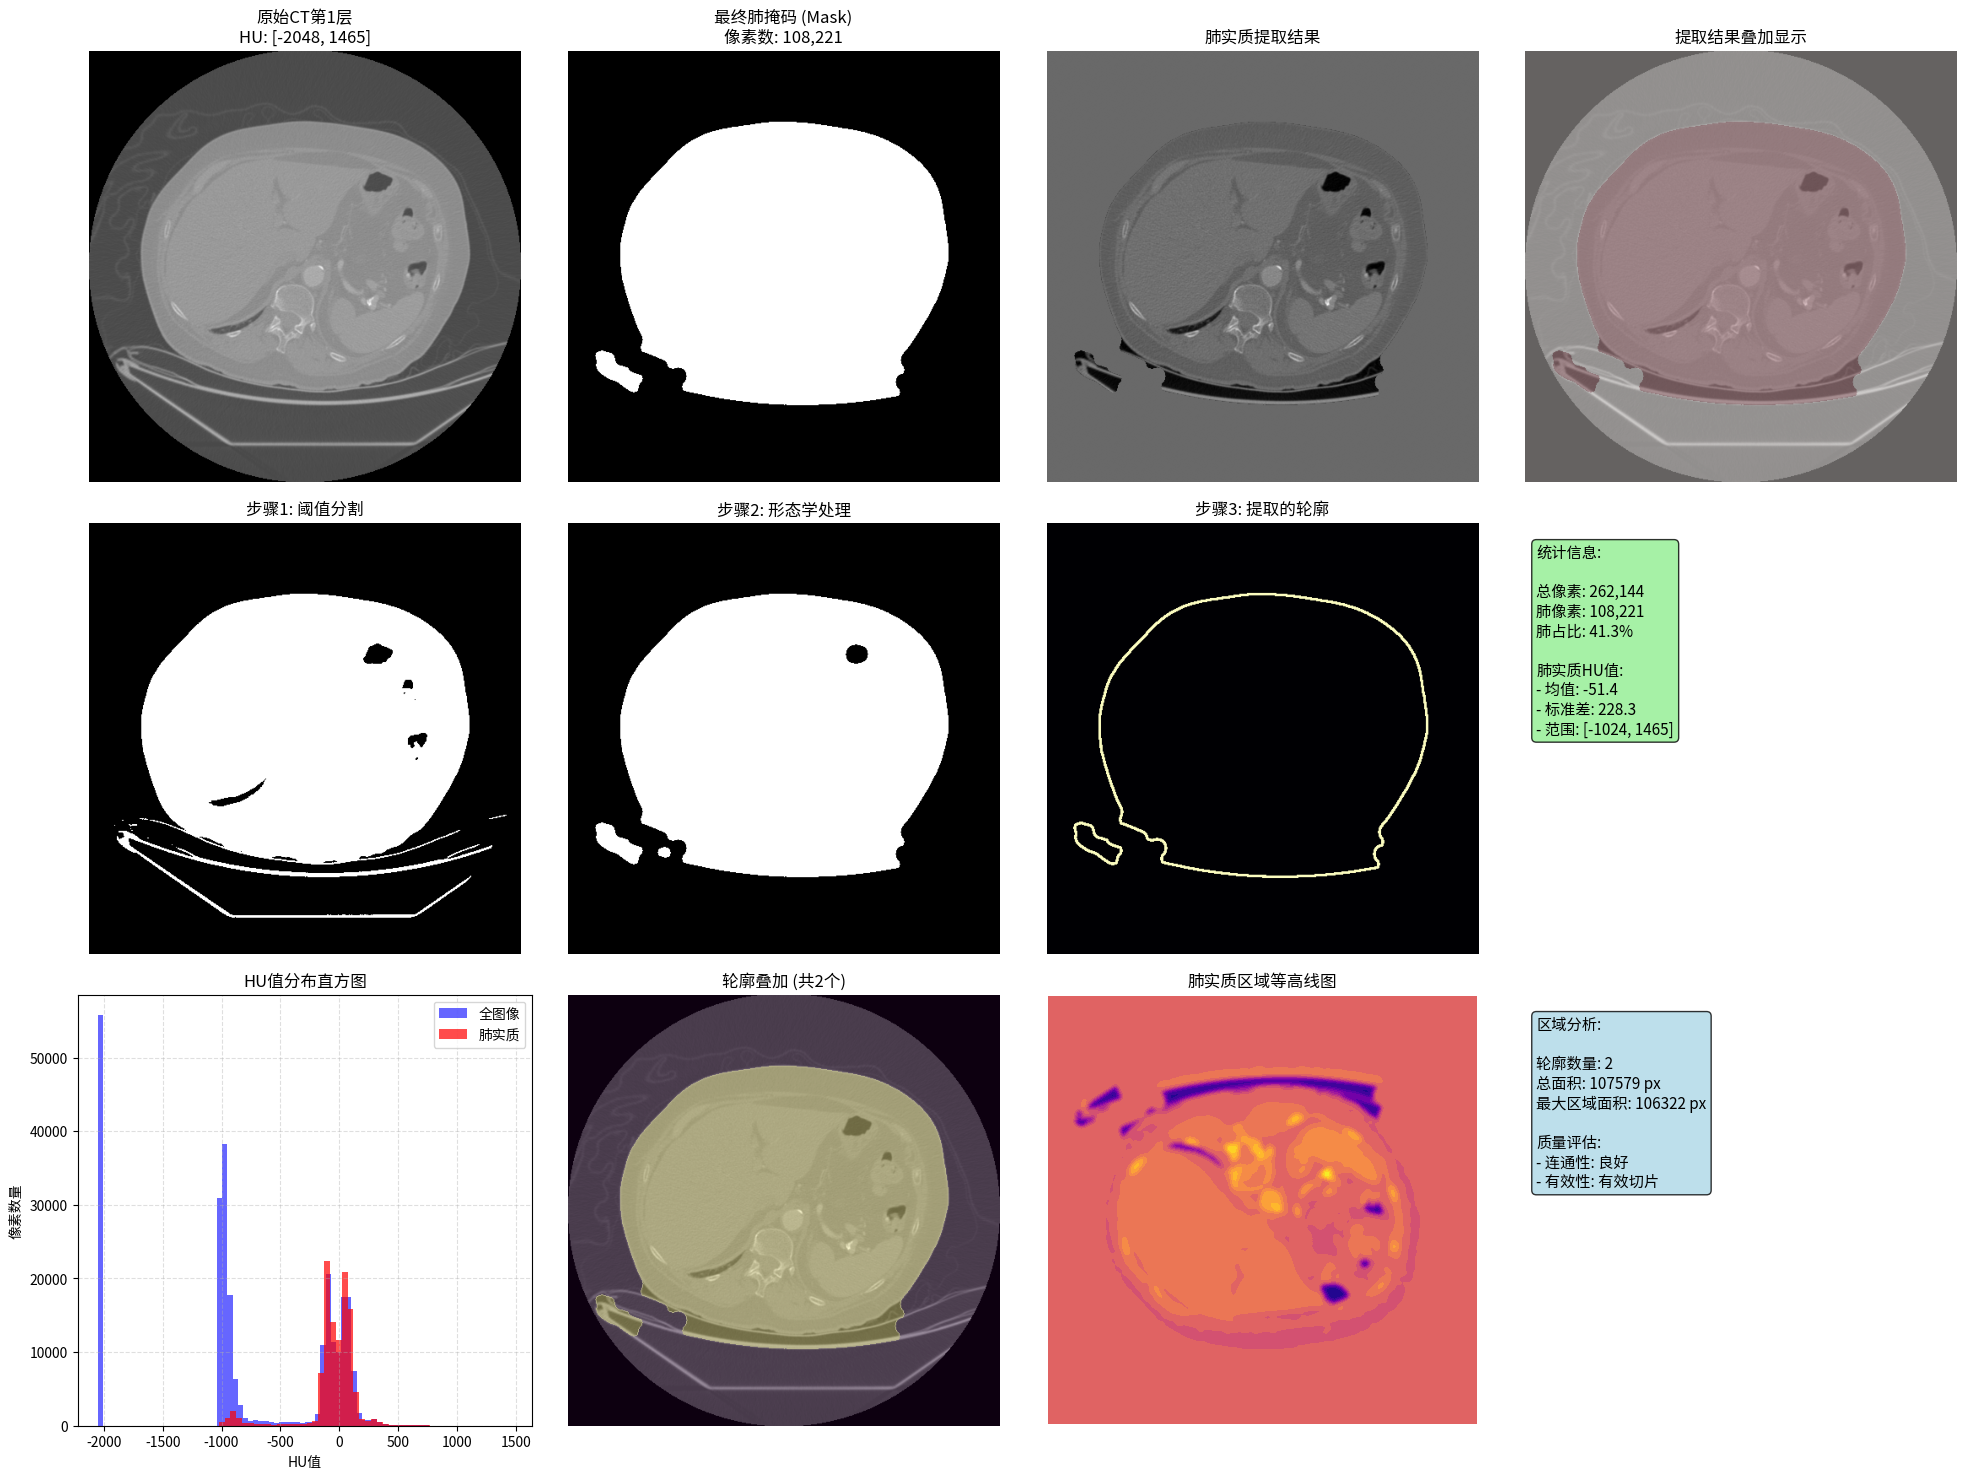


   正在生成第 99 层的分析报告 (2/3)...
📊 详细分析图已保存到: visualization_reports/analysis_report_slice_99.png


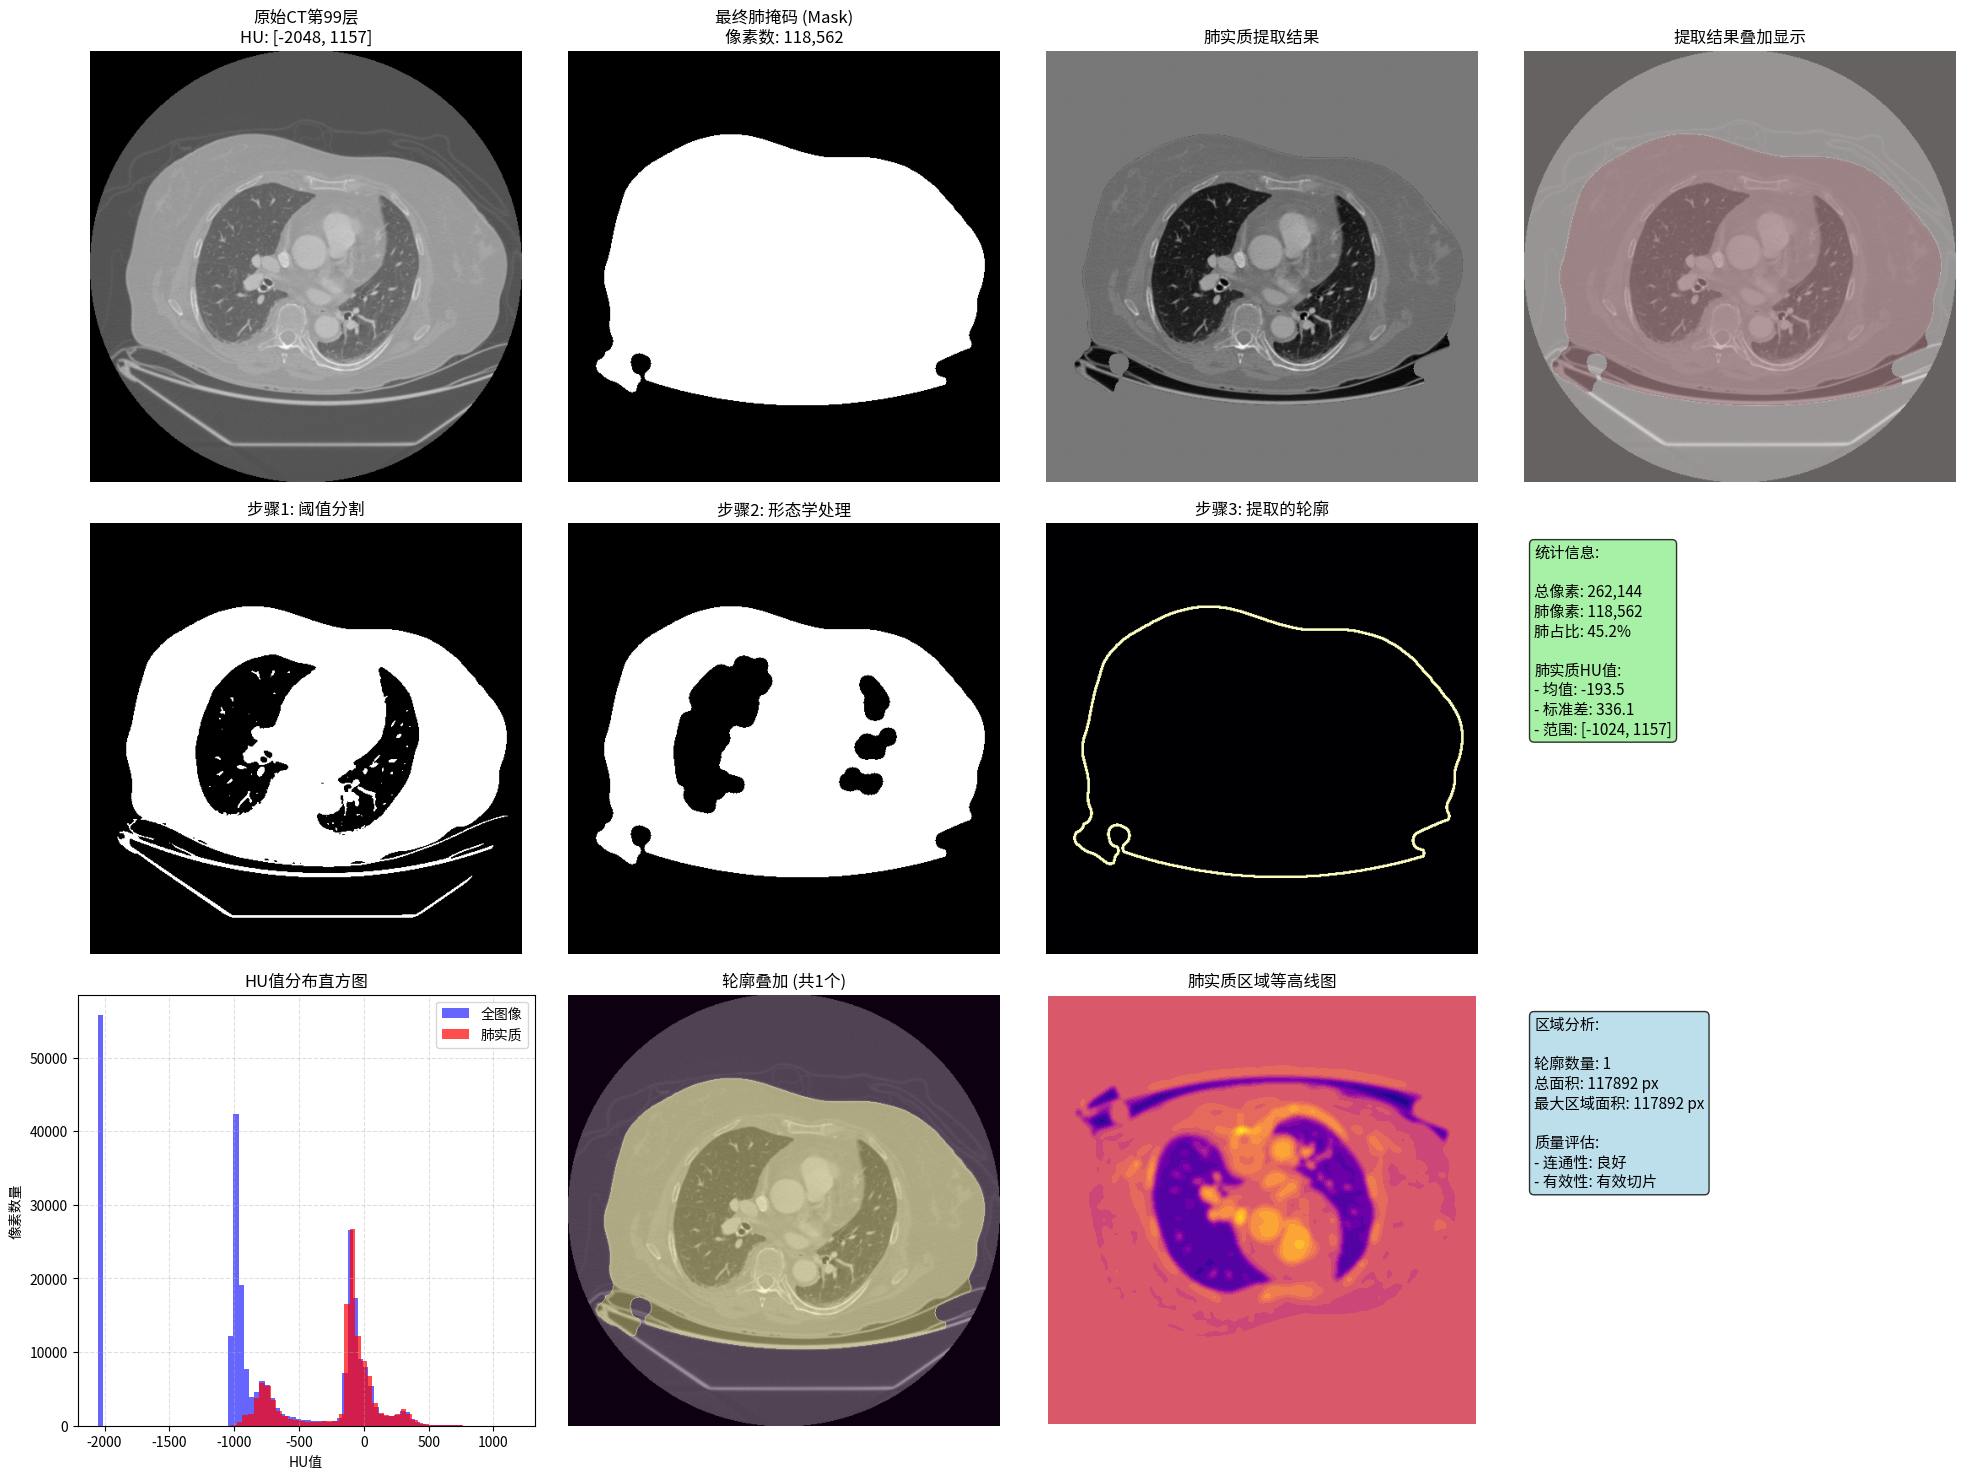


   正在生成第 197 层的分析报告 (3/3)...
📊 详细分析图已保存到: visualization_reports/analysis_report_slice_197.png


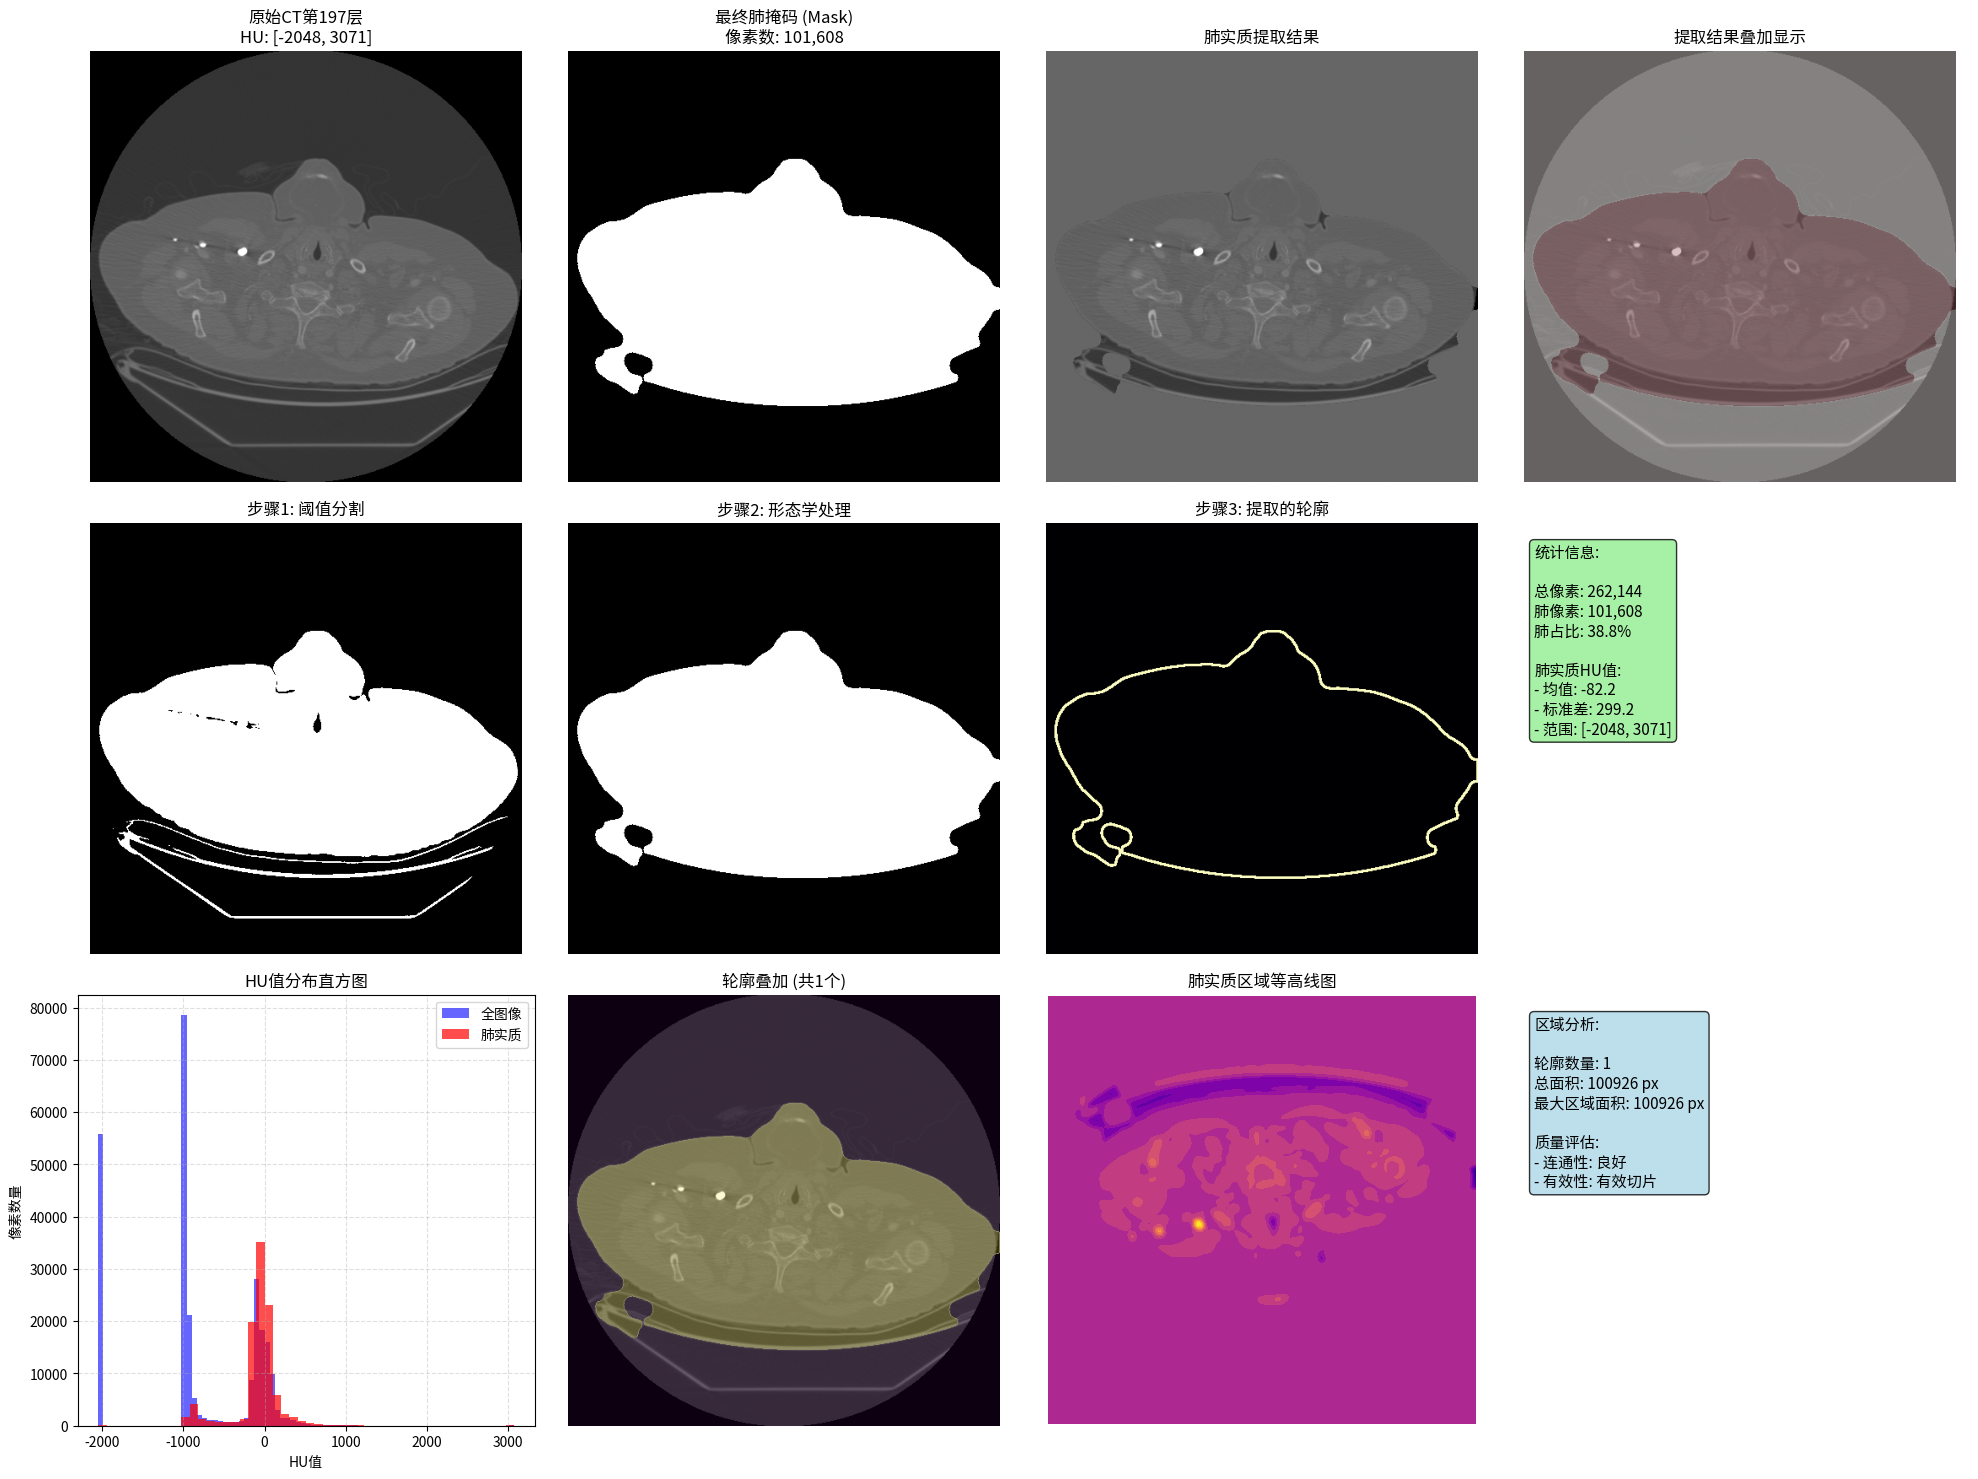


🎉🎉🎉 流程全部执行完毕！🎉🎉🎉


In [65]:
# ===================================================================
#                              ⭐⭐⭐ 执行入口 ⭐⭐⭐
#  数据文件位于 /home/aistudio/lungmaterial/data 目录中
# ===================================================================

# --- 输入文件完整路径 ---
# 修改为完整路径，指向实际的数据文件位置
INPUT_CT_FILE = "/home/aistudio/lungmaterial/data/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd"

# --- 输出目录配置 ---
# (这些目录如果不存在，程序会自动创建)
OUTPUT_DIRECTORY = "lung_extraction_results"    # 用于存放所有切片的提取结果图片
VISUALIZATION_DIR = "visualization_reports"     # 用于存放详细的分析报告图片

# 验证文件是否存在
if os.path.exists(INPUT_CT_FILE):
    print(f"✅ 找到CT文件: {INPUT_CT_FILE}")
    raw_file = INPUT_CT_FILE.replace('.mhd', '.raw')
    if os.path.exists(raw_file):
        print(f"✅ 找到对应的RAW文件: {raw_file}")
    else:
        print(f"❌ 未找到对应的RAW文件: {raw_file}")
else:
    print(f"❌ 未找到CT文件: {INPUT_CT_FILE}")
    print("🔍 正在搜索data目录中的所有.mhd文件...")
    data_dir = "/home/aistudio/lungmaterial/data"
    if os.path.exists(data_dir):
        mhd_files = [f for f in os.listdir(data_dir) if f.endswith('.mhd')]
        print(f"找到以下.mhd文件:")
        for i, f in enumerate(mhd_files):
            print(f"  {i+1}. {f}")
        if mhd_files:
            INPUT_CT_FILE = os.path.join(data_dir, mhd_files[0])
            print(f"📝 将使用第一个文件: {INPUT_CT_FILE}")

# --- 运行主流程 ---
run_lung_segmentation_pipeline(
    ct_path=INPUT_CT_FILE,
    output_dir=OUTPUT_DIRECTORY,
    report_dir=VISUALIZATION_DIR
)